In [42]:
# Andrew Koulogeorge --> Preliminary Analysis 10/30
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
player_data = pd.read_csv("plays.csv")
player_data.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


In [4]:
# number of total plays and number of features
player_data.shape

(12486, 35)

In [5]:
# number of games we have data for
player_data['gameId'].nunique()

136

In [35]:
# features for the play information dataset
player_data.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2'],
      dtype='object')

In [24]:
teams = player_data['possessionTeam'].unique()
teams

array(['ATL', 'PIT', 'LV', 'DEN', 'BUF', 'TEN', 'SF', 'KC', 'SEA', 'GB',
       'NYJ', 'LA', 'JAX', 'DAL', 'DET', 'CAR', 'IND', 'MIN', 'CLE',
       'WAS', 'CIN', 'BAL', 'PHI', 'TB', 'NO', 'ARI', 'NE', 'NYG', 'MIA',
       'CHI', 'HOU', 'LAC'], dtype=object)

In [53]:
# what do we want our cutoff to be?
CUTOFF = 5
player_data["sucsessfulPlay"] = player_data["playResult"] > 5

In [34]:
# want to analyze the team that has the most offensive plays --> Looks like we are going with Arizona!
# idea is that we want to be able to help predict if a play is worth running or not. May not be enough data to predict the outcome of a play for a single team?
offensive_team_grouped = player_data.groupby('possessionTeam')
play_and_team = []
for team in teams:
    num_offensive_plays = len(offensive_team_grouped.get_group(team))
    play_and_team.append((num_offensive_plays,team))
play_and_team.sort()
play_and_team[-1]

(447, 'ARI')

## What information do we want to use that would be helpful for predicting the yards gained on a play?

We dont want to use any of the NFL Next Gen Stat features to do prediction; this is just there own models. We also want to make sure that we are only using data that we can acess before the play starts

Brainstorm:
(1) Is there a time dependency to the outcome of a play? My intution is that there is. Maybe there is a notion of a "hot" offense where if a play gains more than 4 yards than the next play is more likley to also gain more than 4 yards. How do we capture this?


In [58]:
# only look at information about the play thats avalible before the snap
all_team_features = player_data[["gameId", "playId", "ballCarrierId", "ballCarrierDisplayName", 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore','offenseFormation', "defendersInTheBox"]]

all_team_target =player_data[["gameId", "playId", 'possessionTeam', "playResult"]]

team_level_features = all_team_features.groupby("possessionTeam")
team_level_targets = all_team_target.groupby("possessionTeam")

cardinal_features = team_level_features.get_group("ARI")
cardinal_targets = team_level_targets.get_group("ARI")

cardinal_features.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,offenseFormation,defendersInTheBox
42,2022101609,3660,39983,Zach Ertz,4,1,10,ARI,SEA,ARI,7,6:40,19,9,SHOTGUN,5.0
51,2022091811,3698,47784,Kyler Murray,4,4,1,ARI,LV,LV,43,2:28,23,15,I_FORM,8.0
81,2022092510,3686,47784,Kyler Murray,4,1,10,ARI,LA,ARI,38,4:21,9,20,SHOTGUN,5.0
89,2022100911,1566,47808,Marquise Brown,2,3,3,ARI,PHI,PHI,25,5:33,0,14,EMPTY,6.0
92,2022091811,2213,48646,Greg Dortch,3,1,15,ARI,LV,ARI,16,11:05,20,0,SHOTGUN,6.0


In [64]:
cardinal_targets.head()

,gameId,playId,possessionTeam,playResult
42,2022101609,3660,ARI,7
51,2022091811,3698,ARI,2
81,2022092510,3686,ARI,2
89,2022100911,1566,ARI,25
92,2022091811,2213,ARI,29


In [60]:
def visualize_target(target_data, threshold):
    min = target_data.min()
    max = target_data.max()
    median = target_data.median()
    mean = target_data.mean()
    std = target_data.std()

    for i, val in enumerate(target_data):
        if val < threshold:
            plt.plot(i, val, 'ro')  # Red dot for values less than x
        else:
            plt.plot(i, val, 'go')  # Green dot for values greater than x
        
        # Adding lines for statistics
    plt.axhline(y=min, color='b', linestyle='--', label=f'Min: {min}')
    plt.axhline(y=max, color='c', linestyle='--', label=f'Max: {max}')
    plt.axhline(y=std, color='m', linestyle='--', label=f'Std Dev: {std:.2f}')
    plt.axhline(y=mean, color='y', linestyle='-', label=f'Mean: {mean:.2f}')
    plt.axhline(y=median, color='k', linestyle='-', label=f'Median: {median}')

    # Adding labels and title
    plt.xlabel('Play')
    plt.ylabel('Yards Gained')

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.show()



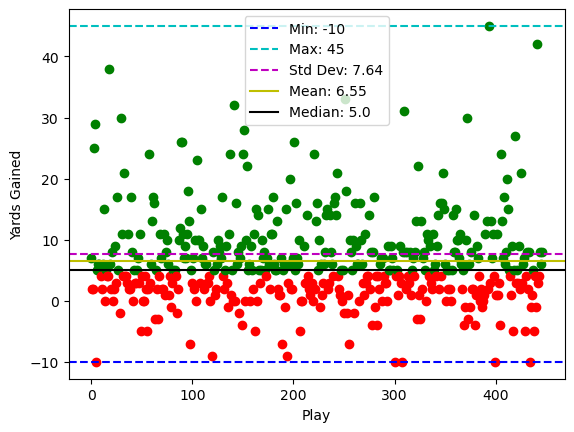

In [62]:
visualize_target(target_data=cardinal_targets["playResult"], threshold=5)